# Neural Network Final Model - Cape Grim, Australia

In [1]:
import pandas as pd
import numpy as np
from joblib import dump
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import sys
sys.path.append('../../')
import config as cfg
import functions as f

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [2]:
site = cfg.site
site_name = cfg.site_dict[site]
assert site == 'CGO', 'This script is only for Cape Grim, Australia. The site can be changed in the config file.'

compound = cfg.compound

print(f"Creating a neural network model for \033[1m{site_name}\033[0;0m.")

Creating a neural network model for Cape Grim, Australia.


### Loading & Initialising Data

In [3]:
data = pd.read_csv(data_path/f'for_model_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,...,v500_7_past,v500_8_past,v500_9_past,v500_10_past,v500_11_past,v500_12_past,v500_13_past,v500_14_past,v500_15_past,v500_16_past
32487,2020-04-24 15:00:00,1.0,7.114488,1.447479,1.297571,11.786820,12.761221,10.718420,10.182069,8.144796,...,-3.924916,0.024155,2.956265,19.079163,16.317783,-24.214008,5.441137,-4.010281,-11.399942,0.655115
28839,2018-06-17 17:00:00,0.0,0.867454,2.901266,2.471687,-2.447451,-0.616147,1.108171,3.866316,-2.135774,...,9.531856,11.013803,1.236005,-3.866784,-13.368054,-12.275691,1.833367,7.322684,16.414509,6.112681
37099,2022-12-22 07:00:00,0.0,-3.540372,-0.654347,1.462433,-4.755540,-2.264988,0.963346,4.591492,0.921575,...,-11.028892,-8.963907,5.545168,12.485143,11.198289,5.700192,-7.576214,-21.153639,-10.183031,-4.730087
26572,2017-05-02 19:00:00,1.0,4.551659,-0.001904,1.254310,5.775073,10.560544,10.816620,10.010985,5.261768,...,10.486994,8.282192,-1.045109,-10.703513,-3.237704,11.516919,22.377665,6.025514,2.026355,5.035260
8607,2007-05-19 15:00:00,1.0,11.215084,2.788129,4.353982,15.668484,13.305241,8.274612,7.339616,12.549480,...,29.905468,0.874846,0.743354,-5.045562,-0.467675,-6.045555,-9.228972,-10.323119,4.895920,-2.980643


In [4]:
train_data = data[(data['time'].dt.year >= 2018) & (data['time'].dt.year <= 2018)]
val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]

print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2018-01-01 01:00:00 -> 2018-12-31 21:00:00. Length: 1876
Val range: 2019-01-01 09:00:00 -> 2019-12-31 23:00:00. Length: 2094
Test range: 2020-01-01 01:00:00 -> 2022-12-31 07:00:00. Length: 5194


### Model

In [5]:
nn_model = MLPClassifier(random_state=42,
                         max_iter=1000, 
                         hidden_layer_sizes=(50,), 
                         shuffle=False,
                         activation='relu', 
                         solver='adam', 
                         alpha=0.05, 
                         learning_rate='constant', 
                         batch_size=100, 
                         early_stopping=True,
                         learning_rate_init=0.001,
                         beta_2=0.9,)

nn_model.fit(X_train, y_train)

class_probabilities_val = nn_model.predict_proba(X_val)
class_probabilities_train = nn_model.predict_proba(X_train)

confidence_threshold = cfg.confidence_threshold

y_pred_val = (class_probabilities_val[:,1] > confidence_threshold).astype(int)
y_pred_train = (class_probabilities_train[:,1] > confidence_threshold).astype(int)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)
misclassification_rate_val = 1 - accuracy_score(y_val, y_pred_val)
misclassification_rate_train = 1 - accuracy_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")
print(f"Misclassification Rate on Training Set = {misclassification_rate_train:.3f}")
print(f"Misclassification Rate on Validation Set = {misclassification_rate_val:.3f}")

Precision on Training Set = 0.954
Precision on Validation Set = 0.924
Recall on Training Set = 0.979
Recall on Validation Set = 0.975
F1 Score on Training Set = 0.966
F1 Score on Validation Set = 0.949
Misclassification Rate on Training Set = 0.059
Misclassification Rate on Validation Set = 0.092


In [6]:
# evaluating model on test set
class_probabilities_test = nn_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:,1] > confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
misclassification_rate_test = 1 - accuracy_score(y_test, y_pred_test)

print(f"Precision on Testing Set = {precision_test:.3f}")
print(f"Recall on Testing Set = {recall_test:.3f}")
print(f"F1 Score on Testing Set = {f1_test:.3f}")
print(f"Misclassification Rate on Testing Set = {misclassification_rate_test:.3f}")

Precision on Testing Set = 0.938
Recall on Testing Set = 0.961
F1 Score on Testing Set = 0.949
Misclassification Rate on Testing Set = 0.085


In [7]:
# saving the model
dump(nn_model, data_path/f'nn_model_{site}.joblib')
dump(nn_model, f'../final_models/nn_model_{site}.joblib')

['../final_models/nn_model_CGO.joblib']

### Confusion Matrix

Text(0.5, 1.0, 'Cape Grim, Australia')

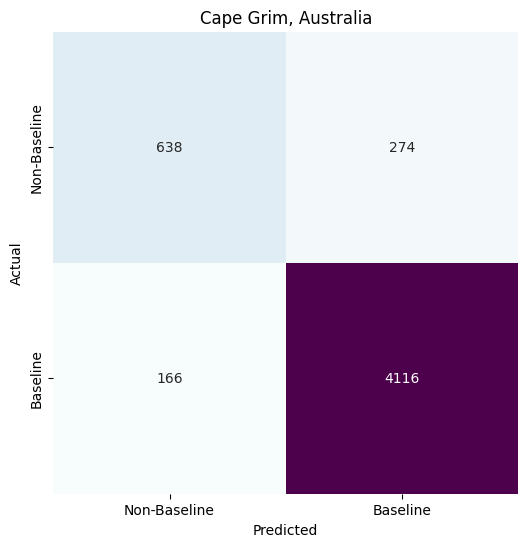

In [7]:
# creating a confusion matrix
conf_matrix = pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'])

conf_matrix.columns = ['Non-Baseline', 'Baseline']
conf_matrix.index = ['Non-Baseline', 'Baseline']

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', cbar=True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.set_title(f'{site_name}')

### Assessing Feature Importance

In [10]:
# grouping features by category i.e. x-wind, y-wind, temporal etc.
u_features = [col for col in data.columns if 'u' in col]
v_features = [col for col in data.columns if 'v' in col]
temporal_features = ['day_of_year', 'time_of_day']
sp = ['sp']
blh = ['blh']

groups = [u_features, v_features, temporal_features, sp, blh]

In [11]:
original_score = accuracy_score(y_train, nn_model.predict(X_train))
importances = {}

for group in groups:
    scores_diff = []
    for _ in range(100):
        X_train_permuted = f.permute_group(X_train, group)
        
        permuted_score = accuracy_score(y_train, nn_model.predict(X_train_permuted))
        scores_diff.append(original_score - permuted_score)
    
    importances[str(group)] = np.mean(scores_diff)

# Sort groups by importance
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=False)

In [12]:
# matching the group names to the sorted importances
n = len(groups)
group_names_sorted = []

for i in range(n):
    name = sorted_importances[i][0]

    if 'u10_0' in name:
        group_names_sorted.append('u-wind')

    elif 'v10_0' in name:
        group_names_sorted.append('v-wind')

    elif 'day_of_year' in name:
        group_names_sorted.append('temporal')

    elif 'sp' in name:
        group_names_sorted.append('sp')

    elif 'blh' in name:
        group_names_sorted.append('blh')

Text(0, 0.5, 'Feature Group')

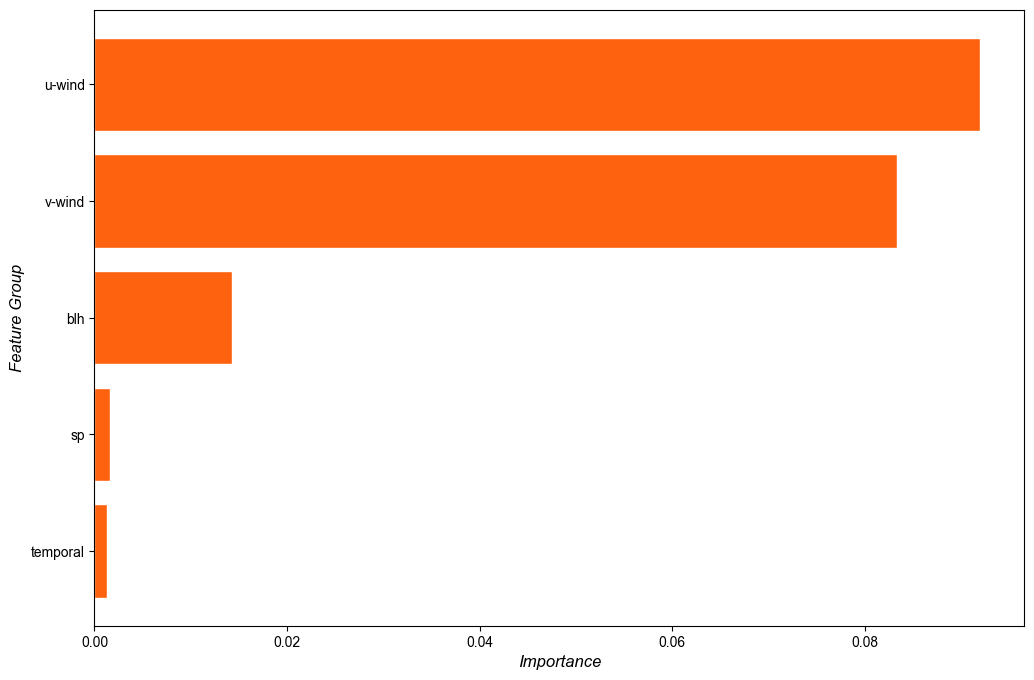

In [13]:
# Plotting the importances of the groups
fig, ax = plt.subplots(figsize=(12, 8))
sns.set_theme(style='ticks', font='Arial')

ax.barh(group_names_sorted, [importance for _, importance in sorted_importances], color='#FF620E')

ax.set_xlabel('Importance', fontsize=12, fontstyle='italic')
ax.set_ylabel('Feature Group', fontsize=12, fontstyle='italic')
# ax.set_title('Permutation Importances', fontsize=14)